To analyze spinning disk confocal micrsocopy images acquired on 1/30/23 to validate VRK1 FRET probes tethered to histone.


20x obj. ch0: CFP, ch1:YFP, ch2: FRET

drug treated after t=0

In [1]:
from nd2reader import ND2Reader
import numpy as np
import scipy as sp
import os,re
import tifffile
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce

import trackpy as tp

from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import segmentation

import seaborn as sns

In [2]:
# data path
fpth = '/home/tyyoo/MitchisonLab/data/SpinningDisk/20230130_cTY107-110_drug/Staurosporine_10uM.nd2'
basename = os.path.basename(fpth)
basename = basename.split('.')[0]
basename

# readnoise background img path
fpth_bg = '/home/tyyoo/MitchisonLab/analysis/FRET_analysis/AVG_read_noise_Station1_20230131.tiff'

seg_ch = 1    # ch used for nuclei segmentation
field_def = {'cTY107':[0,1,2],'cTY108':[3,4,5],'cTY109':[6,7,8],'cTY110':[9,10,11]}

seg_pth = os.path.join(os.path.split(fpth)[0],'seg/'+basename)
os.makedirs(seg_pth,exist_ok=True)

res_pth = os.path.join(os.path.split(fpth)[0],'results/'+basename)
os.makedirs(res_pth,exist_ok=True)

In [3]:
bg_im = tifffile.imread(fpth_bg)

In [4]:
images = ND2Reader(fpth)

metadata = images.metadata
Nframes = metadata['num_frames']
Nfields = len(metadata['fields_of_view'])
chs = metadata['channels']
Nch = len(chs)
loops = metadata['experiment']['loops']
dt = loops[0]['sampling_interval']/1000   # in sec

/home/tyyoo/anaconda3/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (300436.4 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [5]:
def seg_nuclei(im):
    im_blur = filters.gaussian(im,sigma=2)
    
    block_size = 201
    
    n,bins = np.histogram(im_blur.flatten(),bins=1000)
    offset = bins[n.argmax()]*0.8

    thres = filters.threshold_local(im_blur, block_size,offset=-offset)
    
    label = im_blur > thres
    label = morphology.remove_small_objects(label,min_size=300)
    label = morphology.remove_small_holes(label,area_threshold=50)
    label = measure.label(label)
    
    return label


In [6]:
z = 0

df_all = pd.DataFrame()
fig = plt.figure(dpi=150)

for v in range(Nfields):
    for t in range(Nframes):
        im_seg = images.get_frame_2D(c=seg_ch,t=t,z=z,v=v)
        
        label = seg_nuclei(im_seg)
        
        # save label
        im_norm = im_seg.astype(float)
        im_norm = (im_norm-im_norm.min())/(im_norm.max()-im_norm.min())
        seg_contours = segmentation.mark_boundaries(im_norm,label)

        plt.imshow(seg_contours)
        plt.axis('off')
        fig.savefig(os.path.join(seg_pth,'Field%d_t%d.jpg' %(v,t)))
        fig.clear()
        
        df_list = []
        
        # label prop
        rps = measure.regionprops(label)

        dict_list = []
        for rp in rps:
            d = {'field_ind':v,'time_ind':t,'nucl_id':rp.label,
                 'area':rp.area,'eccen':rp.eccentricity, 
                 'x':rp.centroid[0],'y':rp.centroid[1]}
            dict_list.append(d)

        df_list.append(pd.DataFrame(dict_list))
        
        for ch in range(Nch):
            im_ch = images.get_frame_2D(c=ch,t=t,z=0,v=v)
            rps = measure.regionprops(label,im_ch)

            dict_list = []
            for rp in rps:
                d = {'field_ind':v,'time_ind':t,'nucl_id':rp.label,
                    'meanint_%d' %ch:rp.mean_intensity}
                dict_list.append(d)

            df_list.append(pd.DataFrame(dict_list))
            
        # background int
        rps = measure.regionprops(label,bg_im)

        dict_list = []
        for rp in rps:
            d = {'field_ind':v,'time_ind':t,'nucl_id':rp.label,
                'meanint_bg':rp.mean_intensity}
            dict_list.append(d)

        df_list.append(pd.DataFrame(dict_list))
            
        df_measure = reduce(lambda x,y:pd.merge(x,y,on=['field_ind','time_ind','nucl_id']),df_list)
        
        df_all = pd.concat((df_all,df_measure))
        
    print('field %d out of %d' %(v+1,Nfields))

/home/tyyoo/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/tyyoo/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


field 1 out of 12
field 2 out of 12
field 3 out of 12
field 4 out of 12
field 5 out of 12
field 6 out of 12
field 7 out of 12
field 8 out of 12
field 9 out of 12
field 10 out of 12
field 11 out of 12
field 12 out of 12


<Figure size 900x600 with 0 Axes>

In [7]:
for ch in range(Nch):
    df_all['meanint_%d_corr' %ch] = df_all['meanint_%d' %ch] - df_all['meanint_bg']
    
df_all['FRET_CFP_ratio'] = df_all['meanint_2_corr']/df_all['meanint_0_corr']
df_all['FRET_YFP_ratio'] = df_all['meanint_2_corr']/df_all['meanint_1_corr']

In [8]:
def_rearr = {f:k for k,fields in field_def.items() for f in fields}
df_all['class'] = [def_rearr[f] for f in df_all['field_ind']]

In [9]:
df_all['time'] = df_all['time_ind']*dt/60   # in minutes

In [10]:
df_all.head()

,field_ind,time_ind,nucl_id,area,eccen,x,y,meanint_0,meanint_1,meanint_2,meanint_bg,meanint_0_corr,meanint_1_corr,meanint_2_corr,FRET_CFP_ratio,FRET_YFP_ratio,class,time
0,0,0,1,1185,0.785574,13.467511,1052.504641,180.032911,289.983122,152.415190,102.906464,77.126448,187.076659,49.508726,0.641916,0.264644,cTY107,0.0
1,0,0,2,1276,0.663176,92.578370,29.146552,173.798589,285.379310,151.634796,100.573853,73.224737,184.805458,51.060944,0.697318,0.276296,cTY107,0.0
2,0,0,3,1895,0.616313,111.672296,88.412665,194.371504,331.255409,164.928760,101.810532,92.560972,229.444877,63.118228,0.681910,0.275091,cTY107,0.0
3,0,0,4,2344,0.877611,143.960751,1085.133532,170.669369,266.229522,146.995734,102.805161,67.864208,163.424362,44.190573,0.651162,0.270404,cTY107,0.0
4,0,0,5,3402,0.530993,150.422399,638.268665,184.746326,291.652851,154.728395,100.831772,83.914554,190.821079,53.896623,0.642280,0.282446,cTY107,0.0


In [18]:
grp = df_all.groupby('field_ind')

df_tracked = pd.DataFrame()
for ind,df in grp:
    df_t = tp.link_df(df,search_range=50,t_column='time_ind')
    df_tracked = pd.concat((df_tracked,df_t))

Frame 7: 106 trajectories present.


In [19]:
grp = df_tracked.groupby(['field_ind','particle'])
df_tracked_filtered = grp.filter(lambda x:x['time_ind'].count()==Nframes)


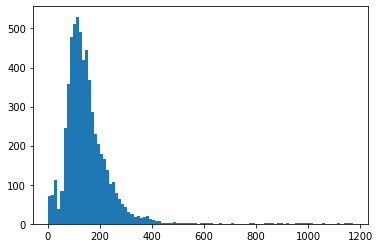

In [20]:
plt.hist(df_tracked_filtered['meanint_0_corr'],bins=100);

In [21]:
df_tracked_filtered = df_tracked_filtered.groupby(['field_ind','particle']).filter(lambda x:(x['meanint_0_corr'].mean()>50) & (x['meanint_0_corr'].mean()<300))

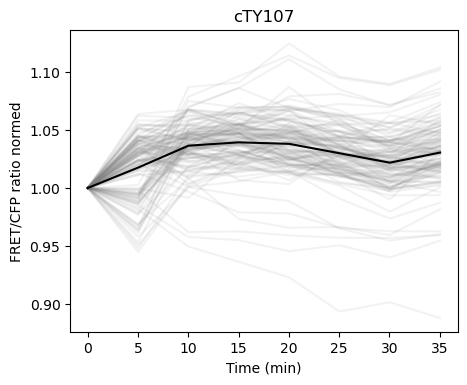

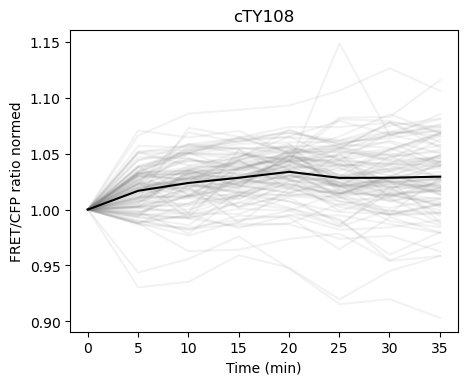

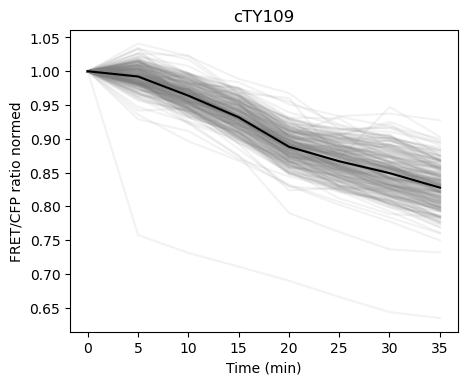

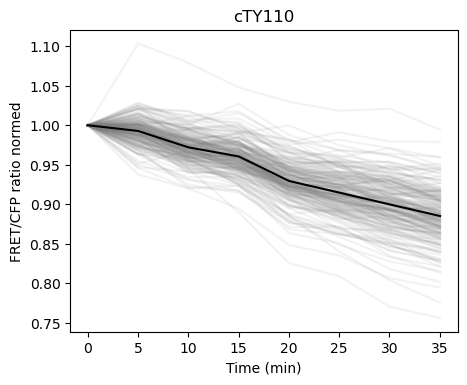

In [22]:
grp_cl = df_tracked_filtered.groupby('class')
cl_list = np.array(list(field_def.keys()))

for cl,df_cl in grp_cl:
    fig = plt.figure(figsize=(5,4),dpi=100)
    
    grp_p = df_cl.groupby(['field_ind','particle'])
    
    normed_ys = []
    for ind,df in grp_p:
        field,p = ind
        
        x = df['time'].values
        y = df['FRET_CFP_ratio'].values
        y = y/y[0]
        
        normed_ys.append(y)
        
        plt.plot(x,y,'gray',alpha=0.1)
    
    normed_ys = np.array(normed_ys)
    
    plt.plot(x,normed_ys.mean(axis=0),'k')
    
    plt.xlabel('Time (min)')
    plt.ylabel('FRET/CFP ratio normed')
    plt.title(cl)
    
    fig.savefig(os.path.join(res_pth,'%s_%s_FRET_CFP_ratio_normed.png' %(basename,cl)))    
    

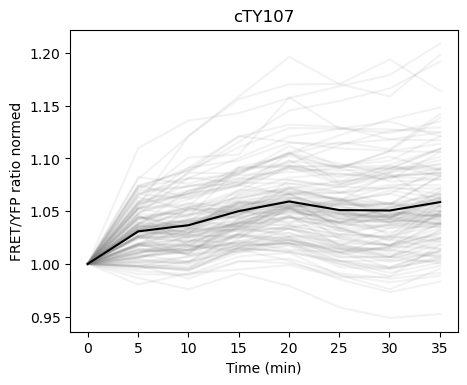

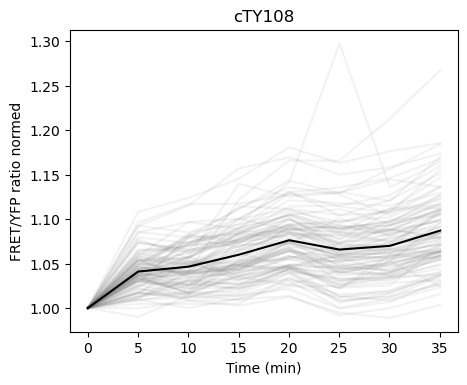

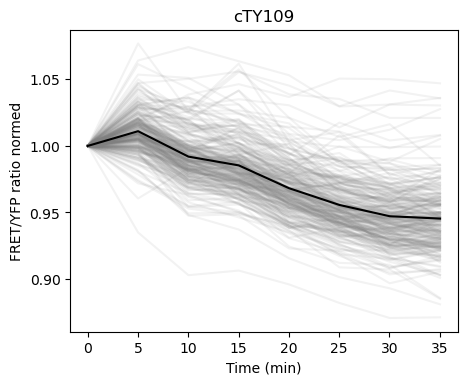

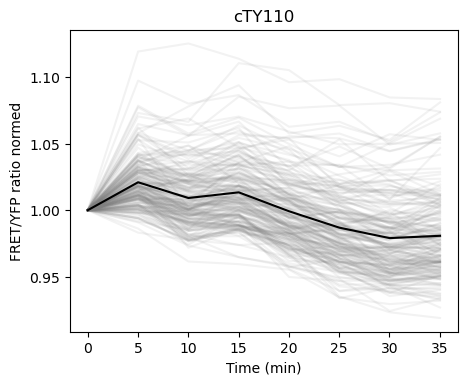

In [23]:
grp_cl = df_tracked_filtered.groupby('class')
cl_list = np.array(list(field_def.keys()))

for cl,df_cl in grp_cl:
    fig = plt.figure(figsize=(5,4),dpi=100)
    
    grp_p = df_cl.groupby(['field_ind','particle'])
    
    normed_ys = []
    for ind,df in grp_p:
        field,p = ind
        
        x = df['time'].values
        y = df['FRET_YFP_ratio'].values
        y = y/y[0]
        
        normed_ys.append(y)
        
        plt.plot(x,y,'gray',alpha=0.1)
    
    normed_ys = np.array(normed_ys)
    
    plt.plot(x,normed_ys.mean(axis=0),'k')
    
    plt.xlabel('Time (min)')
    plt.ylabel('FRET/YFP ratio normed')
    plt.title(cl)
    
    fig.savefig(os.path.join(res_pth,'%s_%s_FRET_YFP_ratio_normed.png' %(basename,cl)))    
    

In [24]:
df_tracked.to_csv(os.path.join(res_pth,'measured_intensity_tracked.csv'))
df_tracked_filtered.to_csv(os.path.join(res_pth,'measured_intensity_tracked_filtered.csv'))